<a href="https://www.kaggle.com/code/tomasramos21/nyc-vehicle-collisions-injury-rate-analysis?scriptVersionId=151783598" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This dataset covers motor vehicle collisions in NYC, where each row represents a specific crash event involving injuries, deaths, or damages exceeding $1000 USD. Our analysis aims to:

1. Track changes in injury proportions over the years
2. Examine the impact of each borough on injury proportions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from math import sqrt,cos,sin,log,exp
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.sandbox.stats.runs import runstest_1samp
from statistics import mean,median,mode
import statsmodels.api as sm
import skfda

In [2]:
df = pd.read_csv("~/Downloads/Motor_Vehicle_Collisions.csv", low_memory=False)
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2034019 entries, 0 to 2034018

Data columns (total 29 columns):

 #   Column                         Dtype  

---  ------                         -----  

 0   CRASH DATE                     object 

 1   CRASH TIME                     object 

 2   BOROUGH                        object 

 3   ZIP CODE                       object 

 4   LATITUDE                       float64

 5   LONGITUDE                      float64

 6   LOCATION                       object 

 7   ON STREET NAME                 object 

 8   CROSS STREET NAME              object 

 9   OFF STREET NAME                object 

 10  NUMBER OF PERSONS INJURED      float64

 11  NUMBER OF PERSONS KILLED       float64

 12  NUMBER OF PEDESTRIANS INJURED  int64  

 13  NUMBER OF PEDESTRIANS KILLED   int64  

 14  NUMBER OF CYCLIST INJURED      int64  

 15  NUMBER OF CYCLIST KILLED       int64  

 16  NUMBER OF MOTORIST INJURED     int64  

 17  NUMBER OF MOTORIST KILLE

# Data Wrangling


To focus on relevant data, we filter rows with non-null values in BOROUGH, NUMBER OF PERSONS INJURED, and NUMBER OF PERSONS KILLED. We then create columns for Year, Death (binary), and Injury (binary):

* __Year:__ Containing the year in which the accident occurred
* __Death:__ Binary (i.e. 1 or 0) column indicating if 1 or more deaths occurred
* __Injury:__ Binary (i.e. 1 or 0) column indicating if 1 or more people were injured

In [3]:
# Create relevant columns
df['YEAR']   = df['CRASH DATE'].map(lambda dt: int(dt[-4:]))
df['DEATH']  = df['NUMBER OF PERSONS KILLED'].map(lambda x: 1 if x > 0.0 else 0)
df['INJURY'] = df['NUMBER OF PERSONS INJURED'].map(lambda x: 1 if x > 0.0 else 0)

# Filtering condition
filtered_df = df[~pd.isnull(df['BOROUGH'])]
filtered_df = filtered_df[~pd.isnull(df['NUMBER OF PERSONS KILLED'])]
filtered_df = filtered_df[~pd.isnull(df['NUMBER OF PERSONS INJURED'])]

# Selected the required columns
filtered_df = filtered_df[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'DEATH', 'INJURY', 'YEAR', 'BOROUGH', 'ON STREET NAME']]

/var/folders/t4/hzdss47s10vc1bfhhz5tx3v80000gn/T/ipykernel_90538/1410393225.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

  filtered_df = filtered_df[~pd.isnull(df['NUMBER OF PERSONS KILLED'])]

/var/folders/t4/hzdss47s10vc1bfhhz5tx3v80000gn/T/ipykernel_90538/1410393225.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

  filtered_df = filtered_df[~pd.isnull(df['NUMBER OF PERSONS INJURED'])]


# Yearly Injury Rates by Borough

We model injury rates by year and borough, using logistic regression and evaluating fit through deviance, Pearson 𝜒², mean-variance plot, runs test, and residual ACF plot.

In [4]:
df_grouped = filtered_df.groupby(['YEAR', 'BOROUGH']).agg(DEATHS             = ('DEATH', 'sum'),
                                                          INJURIES           = ('INJURY', 'sum'),
                                                          ACCIDENTS          = ('DEATH', len)).reset_index()

# Non-Stratified Rates
df_grouped['INJURY_RATE'] = round(df_grouped['INJURIES'] / df_grouped['ACCIDENTS'],2)
df_grouped['DEATH_RATE']  = round(df_grouped['DEATHS'] / df_grouped['ACCIDENTS'],2)
df_grouped['NON_INJURY']  = df_grouped['ACCIDENTS'] - df_grouped['INJURIES']
df_grouped['NON_DEATH']   = df_grouped['ACCIDENTS'] - df_grouped['DEATHS']

# Display Injury and Death Rates
df_grouped.groupby('YEAR').agg(DEATH_RATE_AVG = ('DEATH_RATE', 'mean'), INJURY_RATE_AVG = ('INJURY_RATE', 'mean'))

,DEATH_RATE_AVG,INJURY_RATE_AVG
YEAR,,
2012,0.0,0.202
2013,0.0,0.200
2014,0.0,0.186
2015,0.0,0.174
2016,0.0,0.182
2017,0.0,0.184
2018,0.0,0.182
2019,0.0,0.218
2020,0.0,0.278


---
The death rate is fortunately quite low, making it less compelling to model at a high level. Our emphasis will be on the injury rate, particularly due to its observable oscillations over the years. It maintains minimal fluctuations until 2020, after which it experiences a substantial increase.

## Initial Model Evaluation

The first model exhibits a poor fit with high deviance, AIC, and BIC. The presence of autocorrelation in residuals raises concerns.

In [5]:
model_logit = smf.glm(formula = "INJURIES + NON_INJURY ~ YEAR + C(BOROUGH)",
                      data    = df_grouped,
                      family  = sm.families.Binomial(link = sm.families.family.Binomial.links[0]()))
fit_logit = model_logit.fit()
print(str(fit_logit.summary2()))

                         Results: Generalized linear model


Model:                  GLM                           AIC:               13418.4863

Link Function:          Logit                         BIC:               12594.1573

Dependent Variable:     ['INJURIES', 'NON_INJURY']    Log-Likelihood:    -6703.2   

Date:                   2023-11-22 14:55              LL-Null:           -18071.   

No. Observations:       60                            Deviance:          12815.    

Df Model:               5                             Pearson chi2:      1.30e+04  

Df Residuals:           54                            Scale:             1.0000    

Method:                 IRLS                                                       

-----------------------------------------------------------------------------------

                              Coef.   Std.Err.     z     P>|z|    [0.025    0.975] 

-----------------------------------------------------------------------------------

Inte

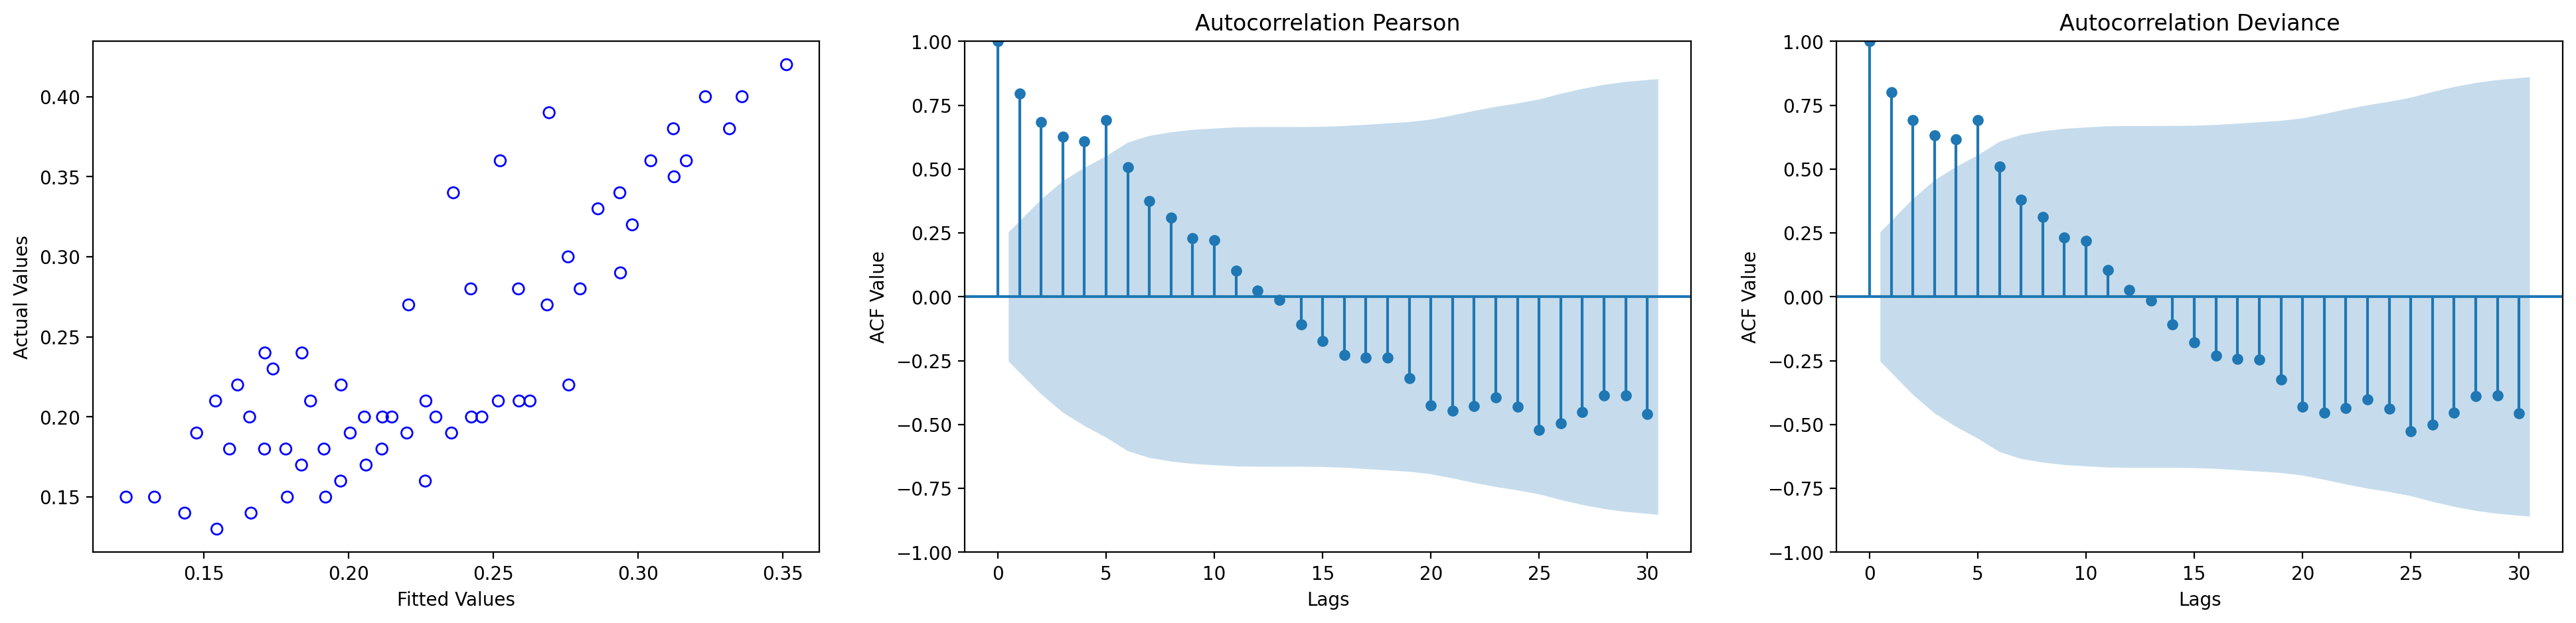





Pearson -> Stat: -6.25 P-val: 0.0

Deviance -> Stat: -6.25 P-val: 0.0






In [6]:
# Set figure properties
plt.rcParams['figure.figsize'] = [24, 5]
plt.rcParams['figure.dpi']     = 200
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Fitted Values to Actual Injury Rate, with LOWESS line
axes[0].scatter(fit_logit.fittedvalues, df_grouped['INJURY_RATE'], facecolors='none', edgecolors='b')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Actual Values')

# ACF plots for Pearson and Deviance residuals
pearson = sm.graphics.tsa.plot_acf(fit_logit.resid_pearson, lags = 30, ax = axes[1])
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('ACF Value')
axes[1].set_title('Autocorrelation Pearson')
deviance = sm.graphics.tsa.plot_acf(fit_logit.resid_deviance, lags = 30, ax = axes[2])
axes[2].set_xlabel('Lags')
axes[2].set_ylabel('ACF Value')
axes[2].set_title('Autocorrelation Deviance')
plt.show()

# Print p-values and statistic for Run's Test
pearson_stat, pearson_p   = runstest_1samp(fit_logit.resid_pearson)
deviance_stat, deviance_p = runstest_1samp(fit_logit.resid_deviance)
print(2*'\n' + f'Pearson -> Stat: {round(pearson_stat,2)} P-val: {round(pearson_p,3)}')
print(f'Deviance -> Stat: {round(deviance_stat,2)} P-val: {round(deviance_p,3)}' + '\n'*2)

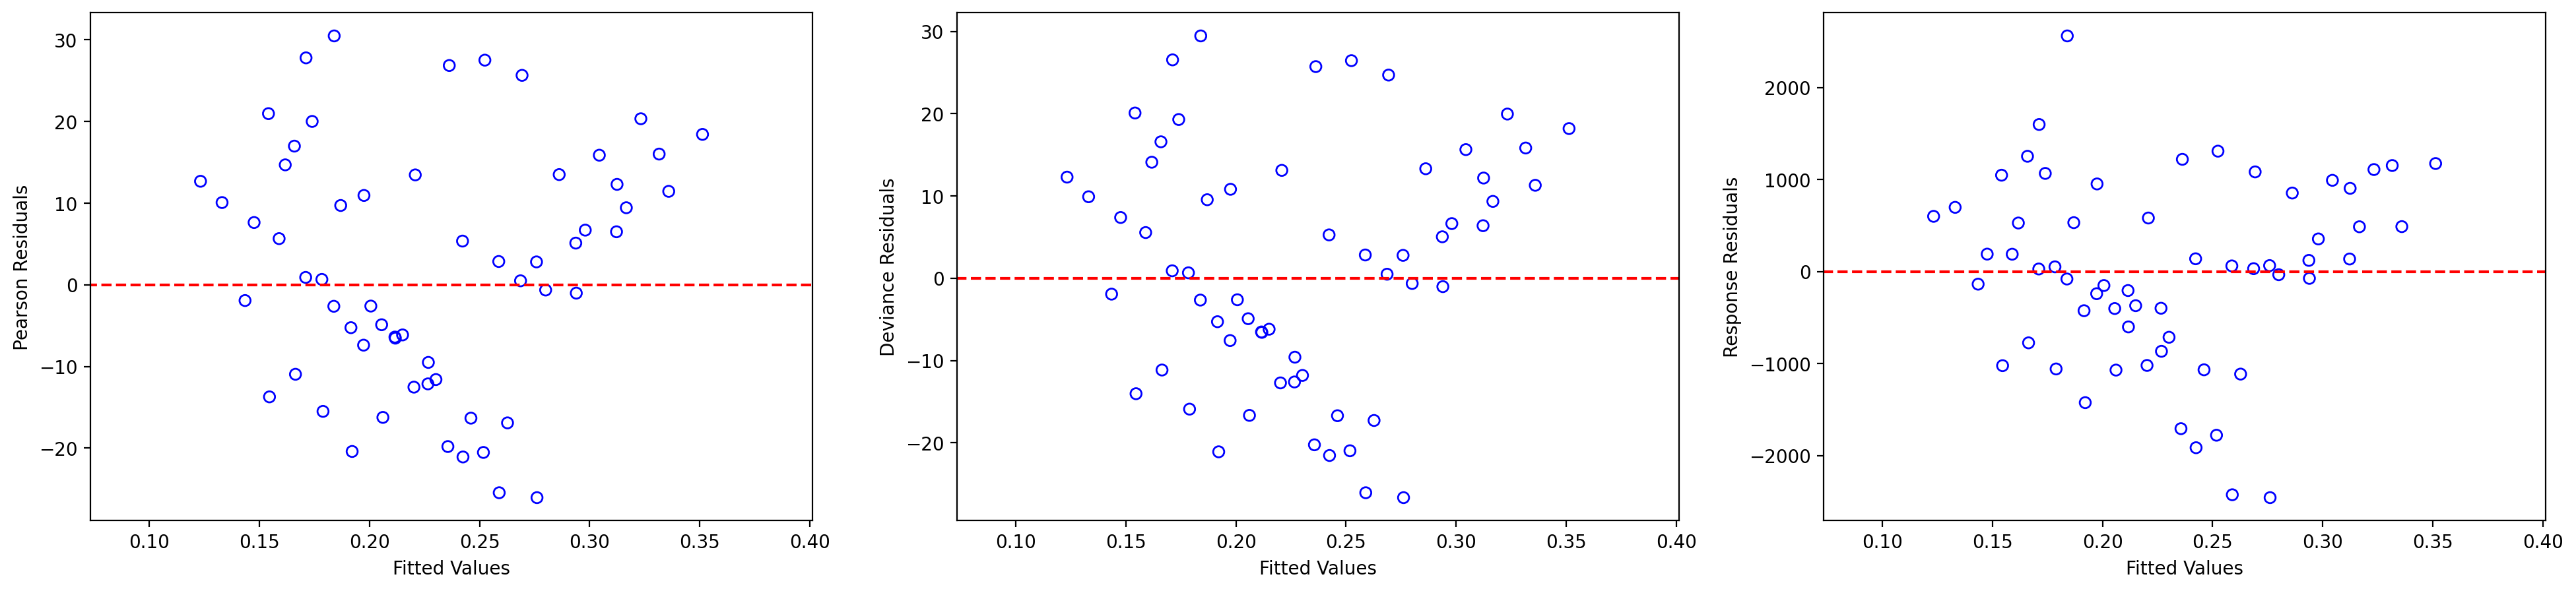

In [7]:
# Set up multi-plot figure
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Pearson Residuals plot
axes[0].scatter(fit_logit.fittedvalues, fit_logit.resid_pearson, facecolors='none', edgecolors='b')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Pearson Residuals')
axes[0].plot((0,1), (0,0), '--', c = 'r')
axes[0].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

# Deviance Residuals plot
axes[1].scatter(fit_logit.fittedvalues, fit_logit.resid_deviance, facecolors='none', edgecolors='b')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Deviance Residuals')
axes[1].plot((0,1), (0,0), '--', c = 'r')
axes[1].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

# Response Residuals plot
axes[2].scatter(fit_logit.fittedvalues, fit_logit.resid_response, facecolors='none', edgecolors='b')
axes[2].set_xlabel('Fitted Values')
axes[2].set_ylabel('Response Residuals')
axes[2].plot((0,1), (0,0), '--', c = 'r')
axes[2].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

plt.show()

## Second Model Evaluation

To address autocorrelation, we treat the year as a categorical variable, resulting in an improved fit with decreased AIC and BIC, and reduced autocorrelation. However, deviance remains high, and autocorrelation persists at lag 5.

In [8]:
model_logit = smf.glm(formula = "INJURIES + NON_INJURY ~ C(YEAR) + C(BOROUGH)",
                      data    = df_grouped,
                      family  = sm.families.Binomial(link = sm.families.family.Binomial.links[0]()))
fit_logit = model_logit.fit()
print(str(fit_logit.summary2()))

                      Results: Generalized linear model


Model:                 GLM                         AIC:             2067.8281

Link Function:         Logit                       BIC:             1264.4425

Dependent Variable:    ['INJURIES', 'NON_INJURY']  Log-Likelihood:  -1017.9  

Date:                  2023-11-22 14:55            LL-Null:         -18071.  

No. Observations:      60                          Deviance:        1444.6   

Df Model:              15                          Pearson chi2:    1.48e+03 

Df Residuals:          44                          Scale:           1.0000   

Method:                IRLS                                                  

-----------------------------------------------------------------------------

                             Coef.  Std.Err.     z     P>|z|   [0.025  0.975]

-----------------------------------------------------------------------------

Intercept                   -1.2897   0.0102 -125.8620 0.0000 -1.3098 -1.

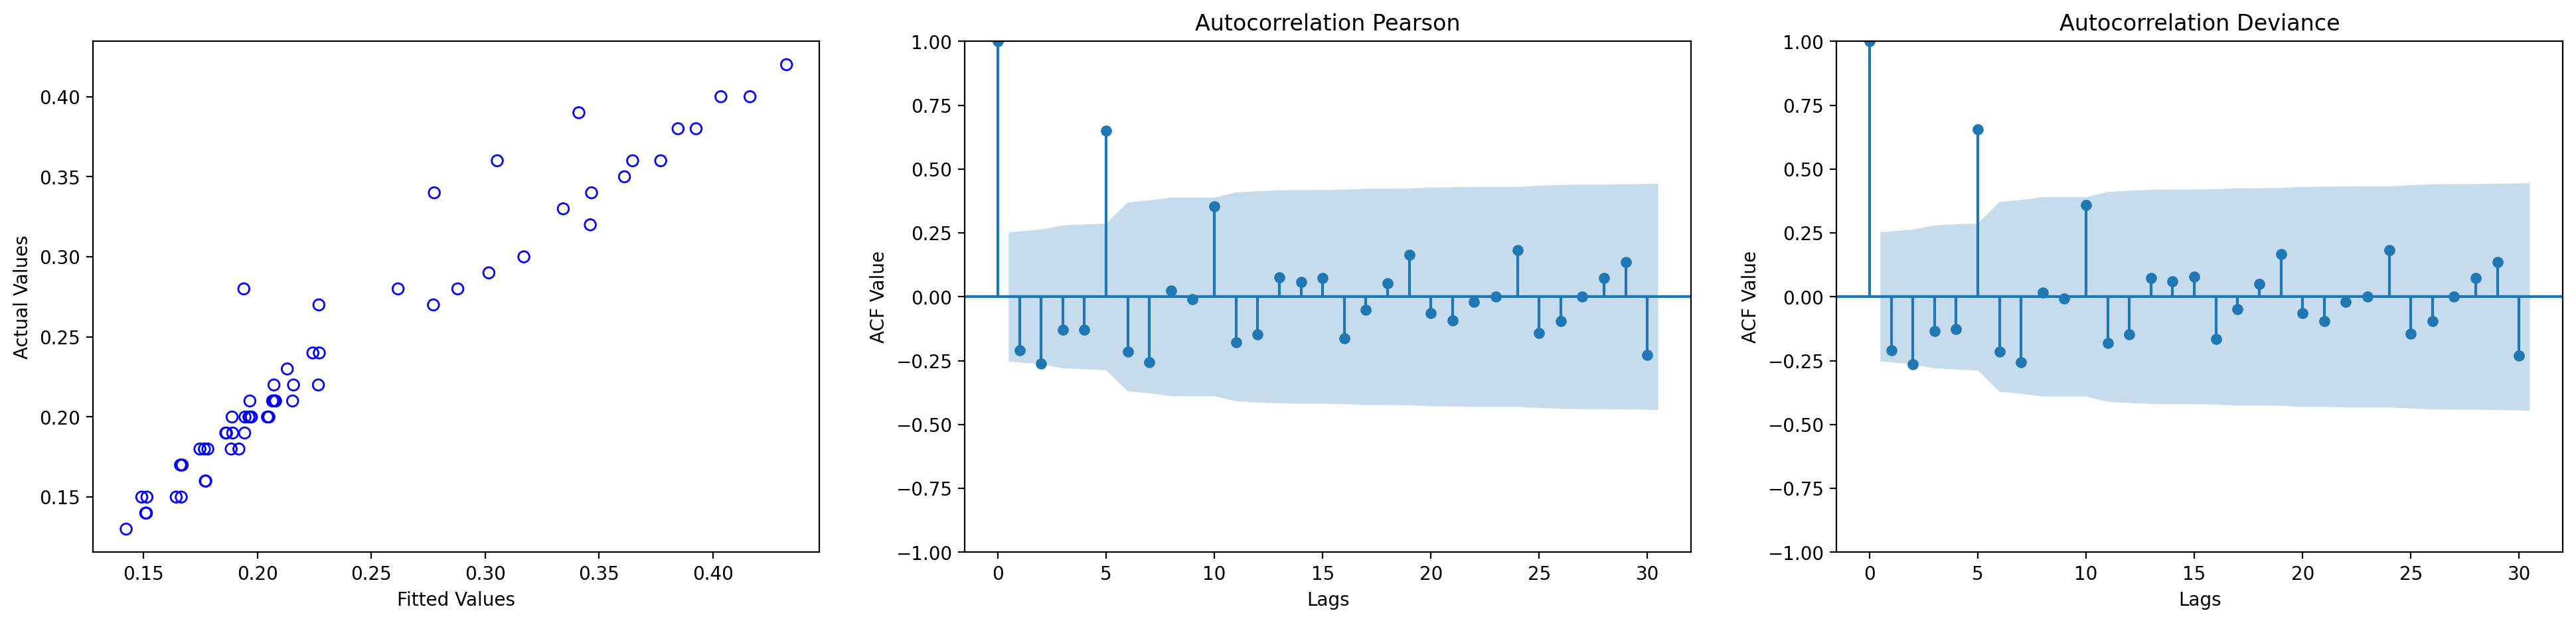





Pearson -> Stat: 0.41 P-val: 0.684

Deviance -> Stat: 0.41 P-val: 0.684






In [9]:
# Set figure properties
plt.rcParams['figure.figsize'] = [24, 5]
plt.rcParams['figure.dpi']     = 200
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Fitted Values to Actual Injury Rate, with LOWESS line
axes[0].scatter(fit_logit.fittedvalues, df_grouped['INJURY_RATE'], facecolors='none', edgecolors='b')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Actual Values')


# ACF plots for Pearson and Deviance residuals
pearson = sm.graphics.tsa.plot_acf(fit_logit.resid_pearson, lags = 30, ax = axes[1])
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('ACF Value')
axes[1].set_title('Autocorrelation Pearson')
deviance = sm.graphics.tsa.plot_acf(fit_logit.resid_deviance, lags = 30, ax = axes[2])
axes[2].set_xlabel('Lags')
axes[2].set_ylabel('ACF Value')
axes[2].set_title('Autocorrelation Deviance')
plt.show()

# Print p-values and statistic for Run's Test
pearson_stat, pearson_p   = runstest_1samp(fit_logit.resid_pearson)
deviance_stat, deviance_p = runstest_1samp(fit_logit.resid_deviance)
print(2*'\n' + f'Pearson -> Stat: {round(pearson_stat,2)} P-val: {round(pearson_p,3)}')
print(f'Deviance -> Stat: {round(deviance_stat,2)} P-val: {round(deviance_p,3)}' + '\n'*2)

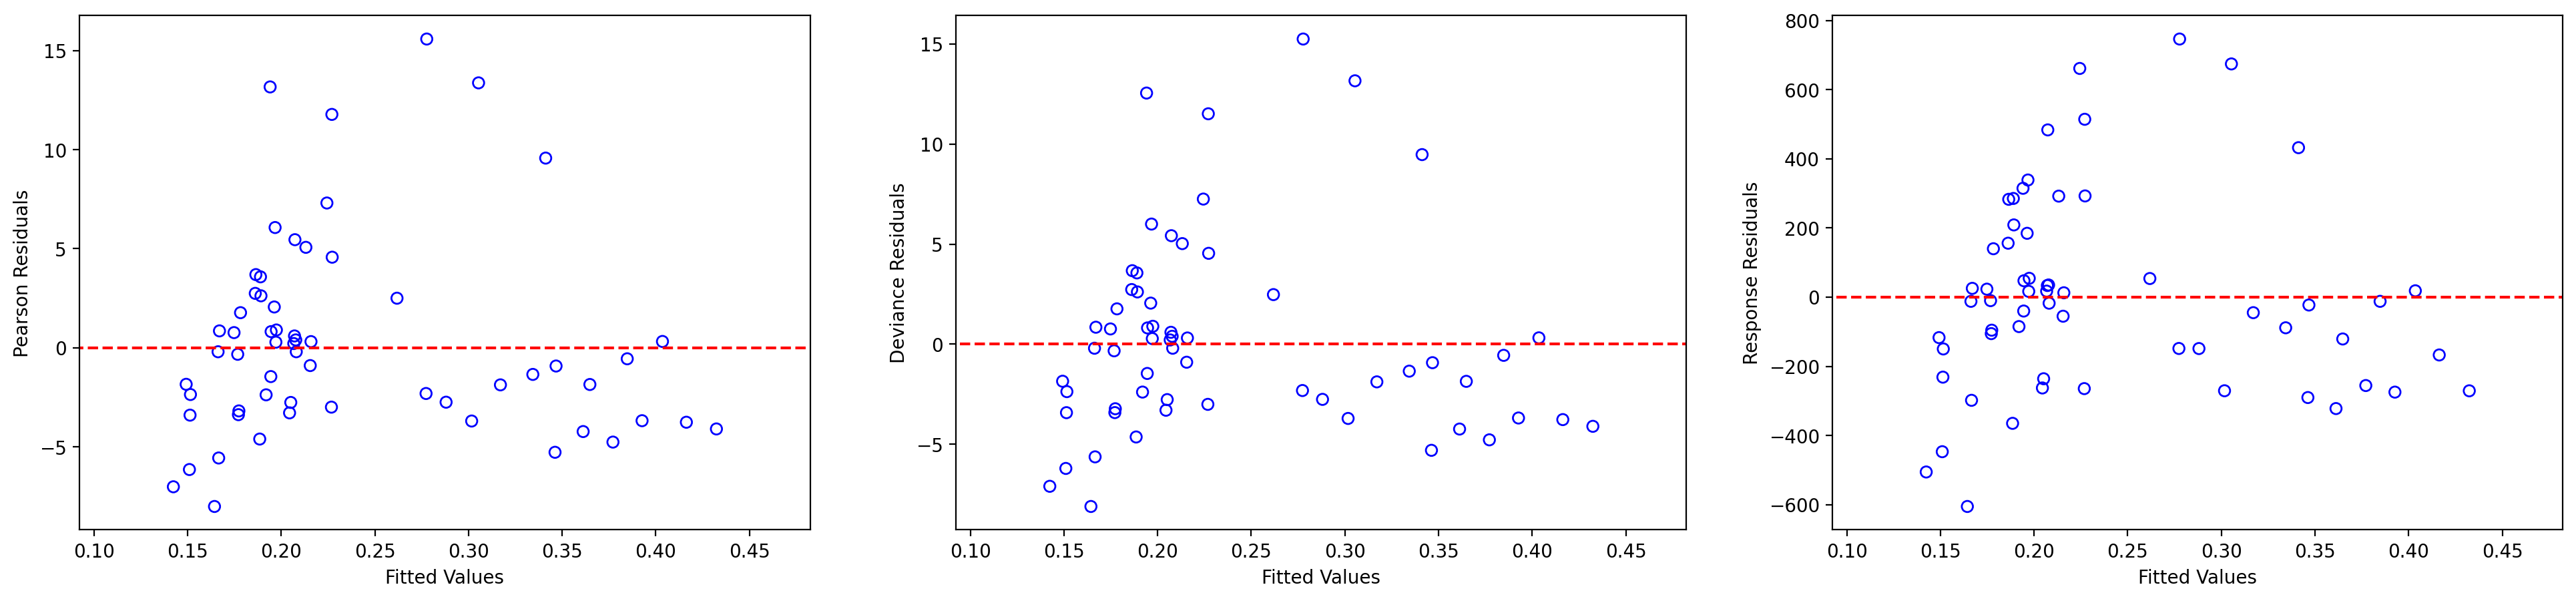

In [10]:
# Set up multi-plot figure
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Pearson Residuals plot
axes[0].scatter(fit_logit.fittedvalues, fit_logit.resid_pearson, facecolors='none', edgecolors='b')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Pearson Residuals')
axes[0].plot((0,1), (0,0), '--', c = 'r')
axes[0].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

# Deviance Residuals plot
axes[1].scatter(fit_logit.fittedvalues, fit_logit.resid_deviance, facecolors='none', edgecolors='b')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Deviance Residuals')
axes[1].plot((0,1), (0,0), '--', c = 'r')
axes[1].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

# Response Residuals plot
axes[2].scatter(fit_logit.fittedvalues, fit_logit.resid_response, facecolors='none', edgecolors='b')
axes[2].set_xlabel('Fitted Values')
axes[2].set_ylabel('Response Residuals')
axes[2].plot((0,1), (0,0), '--', c = 'r')
axes[2].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

plt.show()

## Third Model Evaluation

In an effort to enhance our model, we introduce the interaction between YEAR _(as a continuous variable)_ and BOROUGH. This adjustment significantly improves the model, reducing deviance, Pearson's 𝜒², and AIC/BIC values. Autocorrelation is now within CI boundaries.

In [11]:
model_logit = smf.glm(formula = "INJURIES + NON_INJURY ~ C(YEAR) + C(BOROUGH) + YEAR : C(BOROUGH)",
                      data    = df_grouped,
                      family  = sm.families.Binomial(link = sm.families.family.Binomial.links[0]()))
fit_logit = model_logit.fit()
print(str(fit_logit.summary2()))

                          Results: Generalized linear model


Model:                   GLM                            AIC:                1140.5079

Link Function:           Logit                          BIC:                345.4997 

Dependent Variable:      ['INJURIES', 'NON_INJURY']     Log-Likelihood:     -550.25  

Date:                    2023-11-22 14:55               LL-Null:            -18071.  

No. Observations:        60                             Deviance:           509.27   

Df Model:                19                             Pearson chi2:       523.     

Df Residuals:            40                             Scale:              1.0000   

Method:                  IRLS                                                        

-------------------------------------------------------------------------------------

                                 Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 

--------------------------------------------------------------------

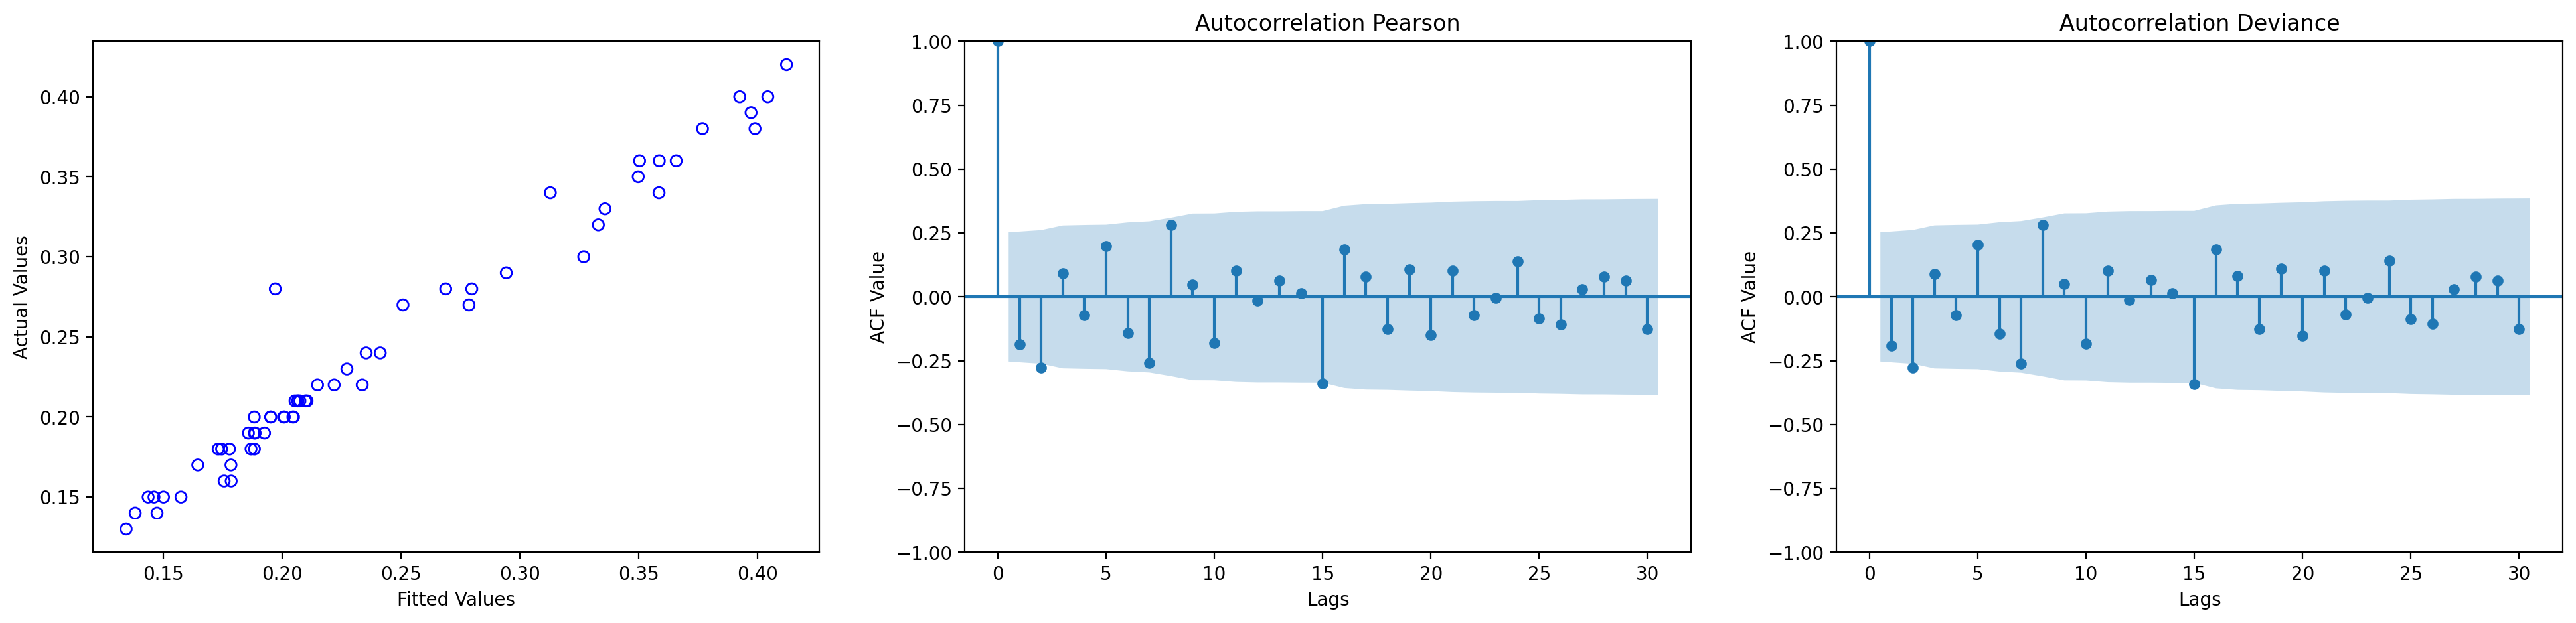





Pearson -> Stat: 1.04 P-val: 0.298

Deviance -> Stat: 1.04 P-val: 0.298






In [12]:
# Set figure properties
plt.rcParams['figure.figsize'] = [24, 5]
plt.rcParams['figure.dpi']     = 200
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Fitted Values to Actual Injury Rate, with LOWESS line
axes[0].scatter(fit_logit.fittedvalues, df_grouped['INJURY_RATE'], facecolors='none', edgecolors='b')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Actual Values')

# ACF plots for Pearson and Deviance residuals
pearson = sm.graphics.tsa.plot_acf(fit_logit.resid_pearson, lags = 30, ax = axes[1])
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('ACF Value')
axes[1].set_title('Autocorrelation Pearson')
deviance = sm.graphics.tsa.plot_acf(fit_logit.resid_deviance, lags = 30, ax = axes[2])
axes[2].set_xlabel('Lags')
axes[2].set_ylabel('ACF Value')
axes[2].set_title('Autocorrelation Deviance')
plt.show()

# Print p-values and statistic for Run's Test
pearson_stat, pearson_p   = runstest_1samp(fit_logit.resid_pearson)
deviance_stat, deviance_p = runstest_1samp(fit_logit.resid_deviance)
print(2*'\n' + f'Pearson -> Stat: {round(pearson_stat,2)} P-val: {round(pearson_p,3)}')
print(f'Deviance -> Stat: {round(deviance_stat,2)} P-val: {round(deviance_p,3)}' + '\n'*2)

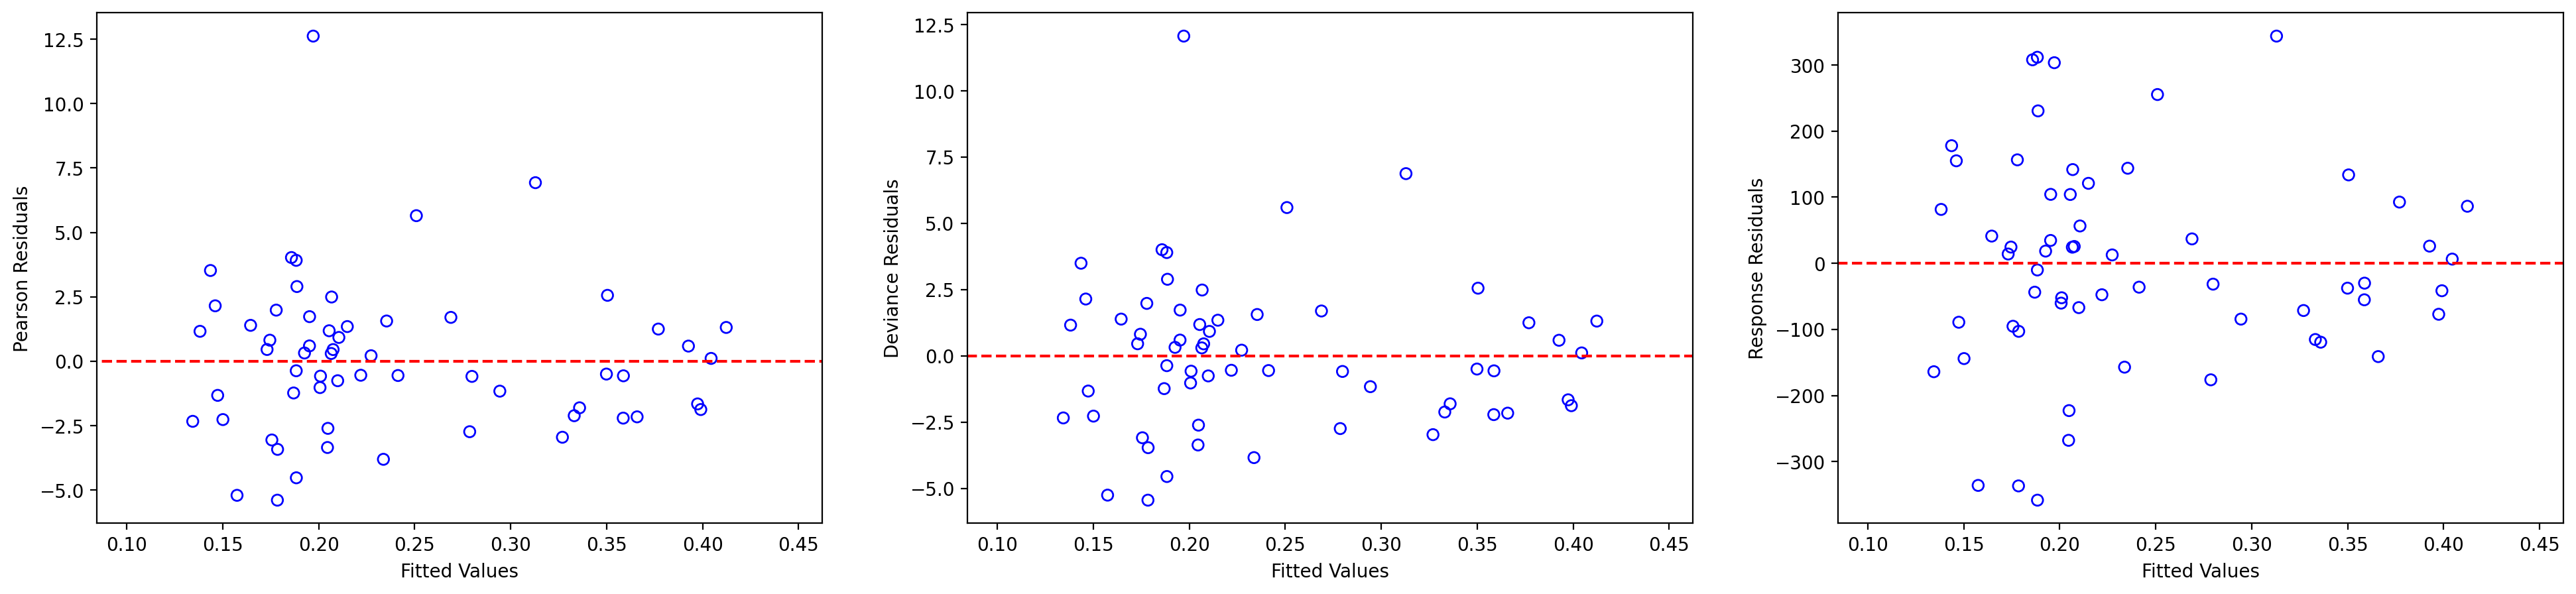

In [13]:
# Set up multi-plot figure
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Pearson Residuals plot
axes[0].scatter(fit_logit.fittedvalues, fit_logit.resid_pearson, facecolors='none', edgecolors='b')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Pearson Residuals')
axes[0].plot((0,1), (0,0), '--', c = 'r')
axes[0].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

# Deviance Residuals plot
axes[1].scatter(fit_logit.fittedvalues, fit_logit.resid_deviance, facecolors='none', edgecolors='b')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Deviance Residuals')
axes[1].plot((0,1), (0,0), '--', c = 'r')
axes[1].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

# Response Residuals plot
axes[2].scatter(fit_logit.fittedvalues, fit_logit.resid_response, facecolors='none', edgecolors='b')
axes[2].set_xlabel('Fitted Values')
axes[2].set_ylabel('Response Residuals')
axes[2].plot((0,1), (0,0), '--', c = 'r')
axes[2].set(xlim = (min(fit_logit.fittedvalues) - 0.05, max(fit_logit.fittedvalues) + 0.05))

plt.show()

## Model Comparisons

Among Logit, Probit, and Complementary LogLog models, the Probit link function provides the best fit.

In [14]:
model_logit = smf.glm(formula = "INJURIES + NON_INJURY ~ C(YEAR) + C(BOROUGH) + YEAR : C(BOROUGH)",
                      data    = df_grouped,
                      family  = sm.families.Binomial(link = sm.families.family.Binomial.links[0]()))

model_probit = smf.glm(formula = "INJURIES + NON_INJURY ~ C(YEAR) + C(BOROUGH) + YEAR : C(BOROUGH)",
                       data    = df_grouped,
                       family  = sm.families.Binomial(link = sm.families.family.Binomial.links[1]()))

model_CLogLog = smf.glm(formula = "INJURIES + NON_INJURY ~ C(YEAR) + C(BOROUGH) + YEAR : C(BOROUGH)",
                        data    = df_grouped,
                        family  = sm.families.Binomial(link = sm.families.family.Binomial.links[5]()))
fit_logit   = model_logit.fit()
fit_probit  = model_probit.fit()
fit_CLogLog = model_CLogLog.fit()
print(str(fit_logit.summary2()))
print(str(fit_probit.summary2()))
print(str(fit_CLogLog.summary2()))

                          Results: Generalized linear model


Model:                   GLM                            AIC:                1140.5079

Link Function:           Logit                          BIC:                345.4997 

Dependent Variable:      ['INJURIES', 'NON_INJURY']     Log-Likelihood:     -550.25  

Date:                    2023-11-22 14:55               LL-Null:            -18071.  

No. Observations:        60                             Deviance:           509.27   

Df Model:                19                             Pearson chi2:       523.     

Df Residuals:            40                             Scale:              1.0000   

Method:                  IRLS                                                        

-------------------------------------------------------------------------------------

                                 Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 

--------------------------------------------------------------------

## Parameter Interpretation & Inference

1. **Temporal Trends:**
   - **Baseline Year (2012):** Significant changes occurred over the years, with a noteworthy upswing in injury rates from 2020 onward.
   - **Comparison with 2012:**
      - Years 2013, 2014, and 2019 had slightly fewer accidents resulting in injuries.
      - The period between 2015 and 2018 witnessed a more substantial drop in injury rates.
      - From 2020 onward, there was a significant year-on-year increase in injury rates.

2. **Borough Influence:**
   - **Baseline Borough (The Bronx):**
      - Brooklyn exhibited fewer injuries on average.
      - Queens and Staten Island experienced lower injury rates on average.
      - Manhattan consistently had notably lower injury rates compared to The Bronx.

3. **Time Influence on Boroughs:**
   - **The Bronx:** Slight decrease in injury rates over time.
   - **Brooklyn:** Slight increase, but changes are not statistically significant.
   - **Queens and Staten Island:** Increased injury rates over the years, particularly noticeable.
   - **Manhattan:** Experiences a slight increase, but the changes are not statistically significant.

In [15]:
print(str(fit_probit.summary()))

                     Generalized Linear Model Regression Results                      


Dep. Variable:     ['INJURIES', 'NON_INJURY']   No. Observations:                   60

Model:                                    GLM   Df Residuals:                       40

Model Family:                        Binomial   Df Model:                           19

Link Function:                         Probit   Scale:                          1.0000

Method:                                  IRLS   Log-Likelihood:                -544.73

Date:                        Wed, 22 Nov 2023   Deviance:                       498.23

Time:                                14:55:43   Pearson chi2:                     511.

No. Iterations:                             5   Pseudo R-squ. (CS):              1.000

Covariance Type:                    nonrobust                                         


                                     coef    std err          z      P>|z|      [0.025      0.975]

------------------

## Visualizations

1. **Box Plots:**
   - **Overview:** Reflects a general increase in injury rates over the years.
   - **Insights:** Indicates the spread and central tendency of injury rates, showcasing the overall temporal trend.

2. **PDF Plots:**
   - **Distribution Shapes:** All boroughs exhibit similar shapes.
   - **Observations:** Each distribution has a mode followed by a slight drop and a second "hump," indicative of an increase in injuries over the years.
   - **Borough Variations:** The Bronx, Brooklyn, and Queens show a significant overlap, while Staten Island is slightly shifted to the left, and Manhattan is notably so.

3. **CDF Plots:**
   - **Probability Distribution:** Demonstrates how Manhattan and Staten Island have a higher probability of observing lower injury rates compared to other boroughs.
   - **Insights:** Highlights the varying likelihoods of different injury rate ranges across boroughs, providing a nuanced perspective on the data.

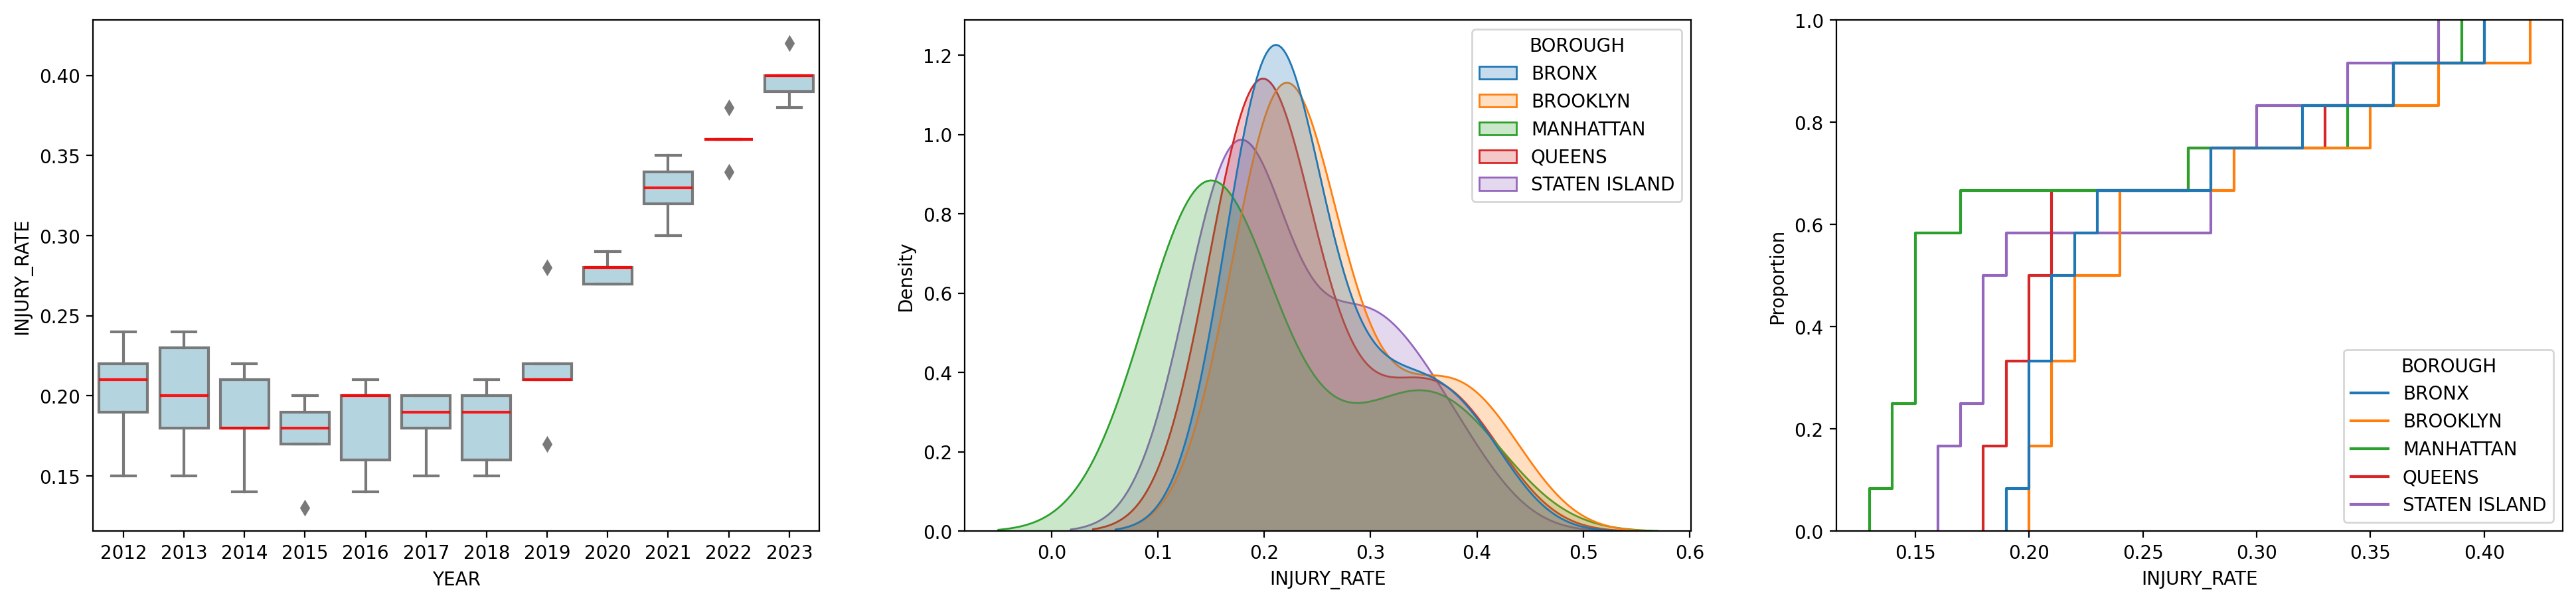

In [16]:
# Temporarily disable warnings
warnings.filterwarnings('ignore')

# Set Figure properties
fig, axes = plt.subplots(ncols = 3, nrows = 1)

# Injury rates per YEAR and BOROUGH
box = sns.boxplot(data = df_grouped, x = 'YEAR', y = 'INJURY_RATE', color = 'lightblue', medianprops = dict(color="red", alpha = 0.9), ax = axes[0])
dis = sns.kdeplot(data = df_grouped, x = 'INJURY_RATE', hue = 'BOROUGH', fill = True, ax = axes[1])
cdf = sns.ecdfplot(data = df_grouped, x = 'INJURY_RATE', hue = 'BOROUGH', ax = axes[2])

# Enable warnings
warnings.filterwarnings('default')

# Identifying Growing Injury "Hotspots"

While we've established that, on average, injury rates have increased since 2019, it's crucial to pinpoint where these increases were most pronounced. This information is vital for traffic police to identify specific streets requiring heightened monitoring or control measures such as adjusted speed limits. Therefore, our next step involves identifying the streets where these accentuated increases in injury are occurring.

In [17]:
filtered_df['ON STREET NAME'] = filtered_df['ON STREET NAME'].astype(str).map(lambda street: street.lstrip().rstrip().upper())
streets = filtered_df.groupby(['YEAR', 'ON STREET NAME']).agg(INJURIES  = ('INJURY', 'sum'), ACCIDENTS = ('DEATH', len)).reset_index()
streets['INJURY_RATE'] = round(streets['INJURIES'] / streets['ACCIDENTS'],2)
streets['SIG RATE'] = streets['INJURY_RATE'].map(lambda x: 1 if x > 0.1 else 0)
streets = streets[streets['YEAR'] >= 2018]

Mean: 24.61, Median: 4.0, Mode: 1


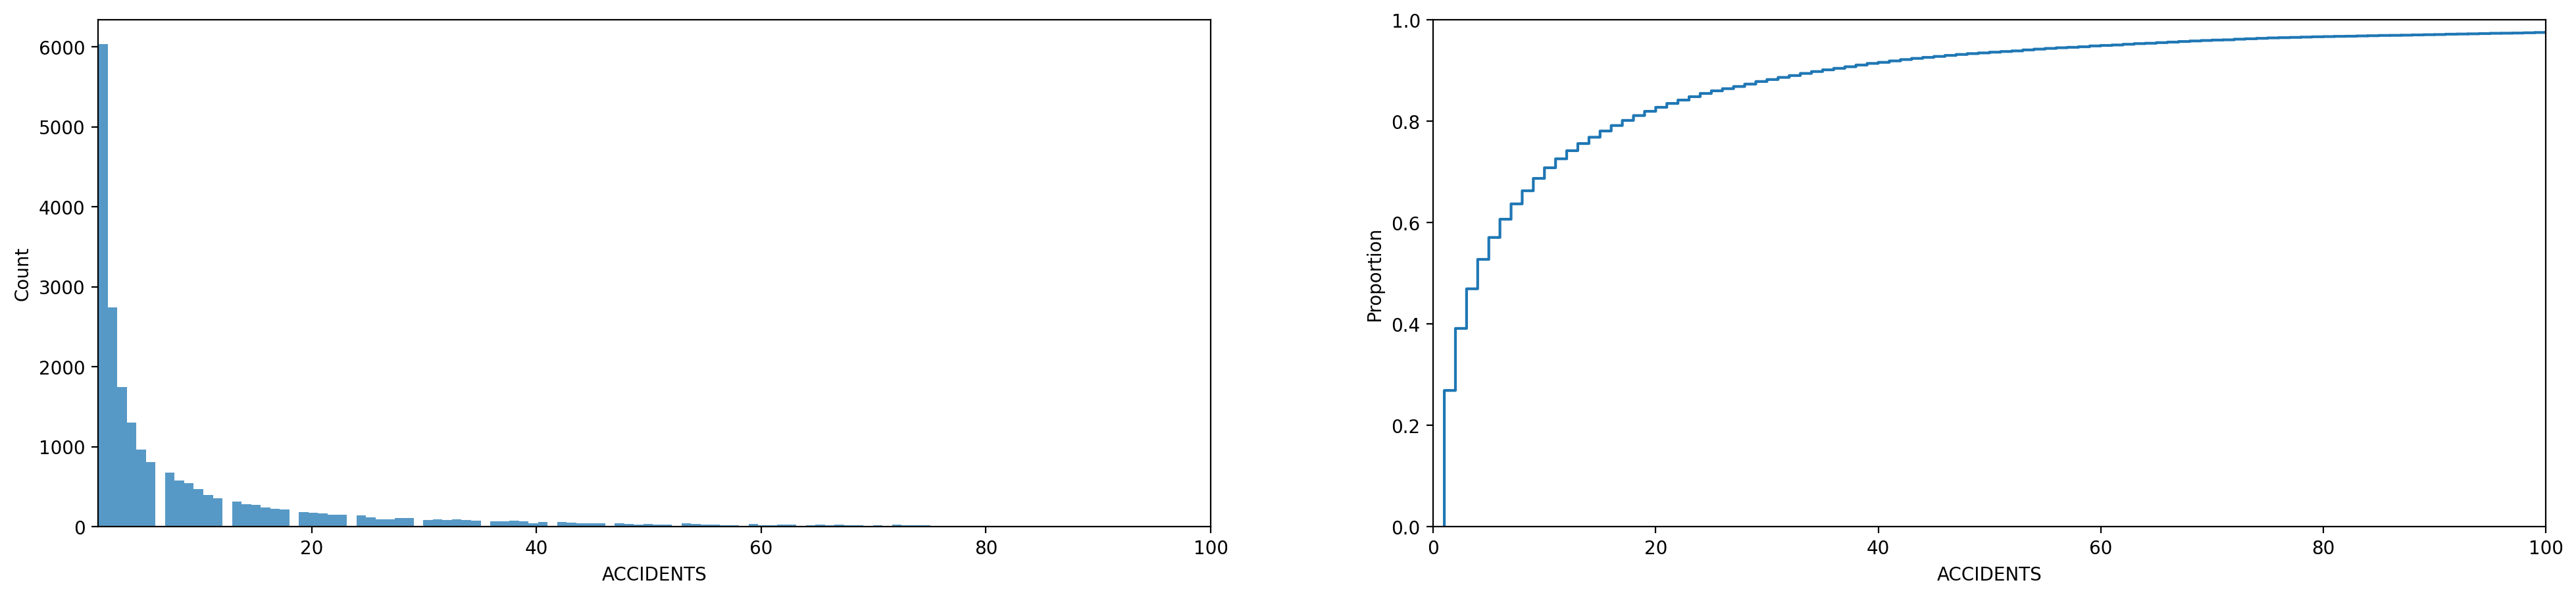

In [18]:
# Temporarily disable warnings
warnings.filterwarnings('ignore')

# Set Figure properties
fig, axes = plt.subplots(ncols = 2, nrows = 1)

dis = sns.histplot(data = streets, x = 'ACCIDENTS', fill = True, ax = axes[0])
axes[0].set(xlim = (1,100))
cdf = sns.ecdfplot(data = streets, x = 'ACCIDENTS', ax = axes[1])
axes[1].set(xlim = (0,100))

accidents_col = streets['ACCIDENTS']
print(f'Mean: {round(mean(accidents_col),2)}, Median: {median(accidents_col)}, Mode: {mode(accidents_col)}')

# Enable warnings
warnings.filterwarnings('default')

## Filtering Relevant Streets

The plots and lines above illustrate that, on average, streets experience 24 accidents from the year 2018 onwards. To narrow down our focus, we will filter the data for streets that have had a minimum of 30 accidents in the last 6 years (2018 to 2023). This targeted approach aims to identify streets already known for a substantial number of accidents.

In [19]:
streets = streets[streets['ACCIDENTS'] >= 30]
temp = streets.groupby(['ON STREET NAME']).agg(YEAR_PRESENCE = ('YEAR', 'unique'), SIGS = ('SIG RATE', 'sum')).reset_index()
temp['TOTAL YEARS'] = temp['YEAR_PRESENCE'].apply(len)
temp = temp[temp['SIGS'] == 6]
temp = temp[['ON STREET NAME', 'TOTAL YEARS']]

## Clustering Injury Rate Derivatives

To identify streets experiencing the highest increases in injury rates, Functional Data analysis is employed. In this process, injury rate proportions are represented as functions over time using B-splines, allowing us to take their derivatives and cluster them.

The subsequent plots reveal a distinct pattern: around the year 2021, derivatives either peak and then drop for one group (Group 0), remain stable for another (Group 1), or slightly reduce and then increase again (Group 2). This effective split categorizes the data into three groups based on the behavior of injury rate derivatives.

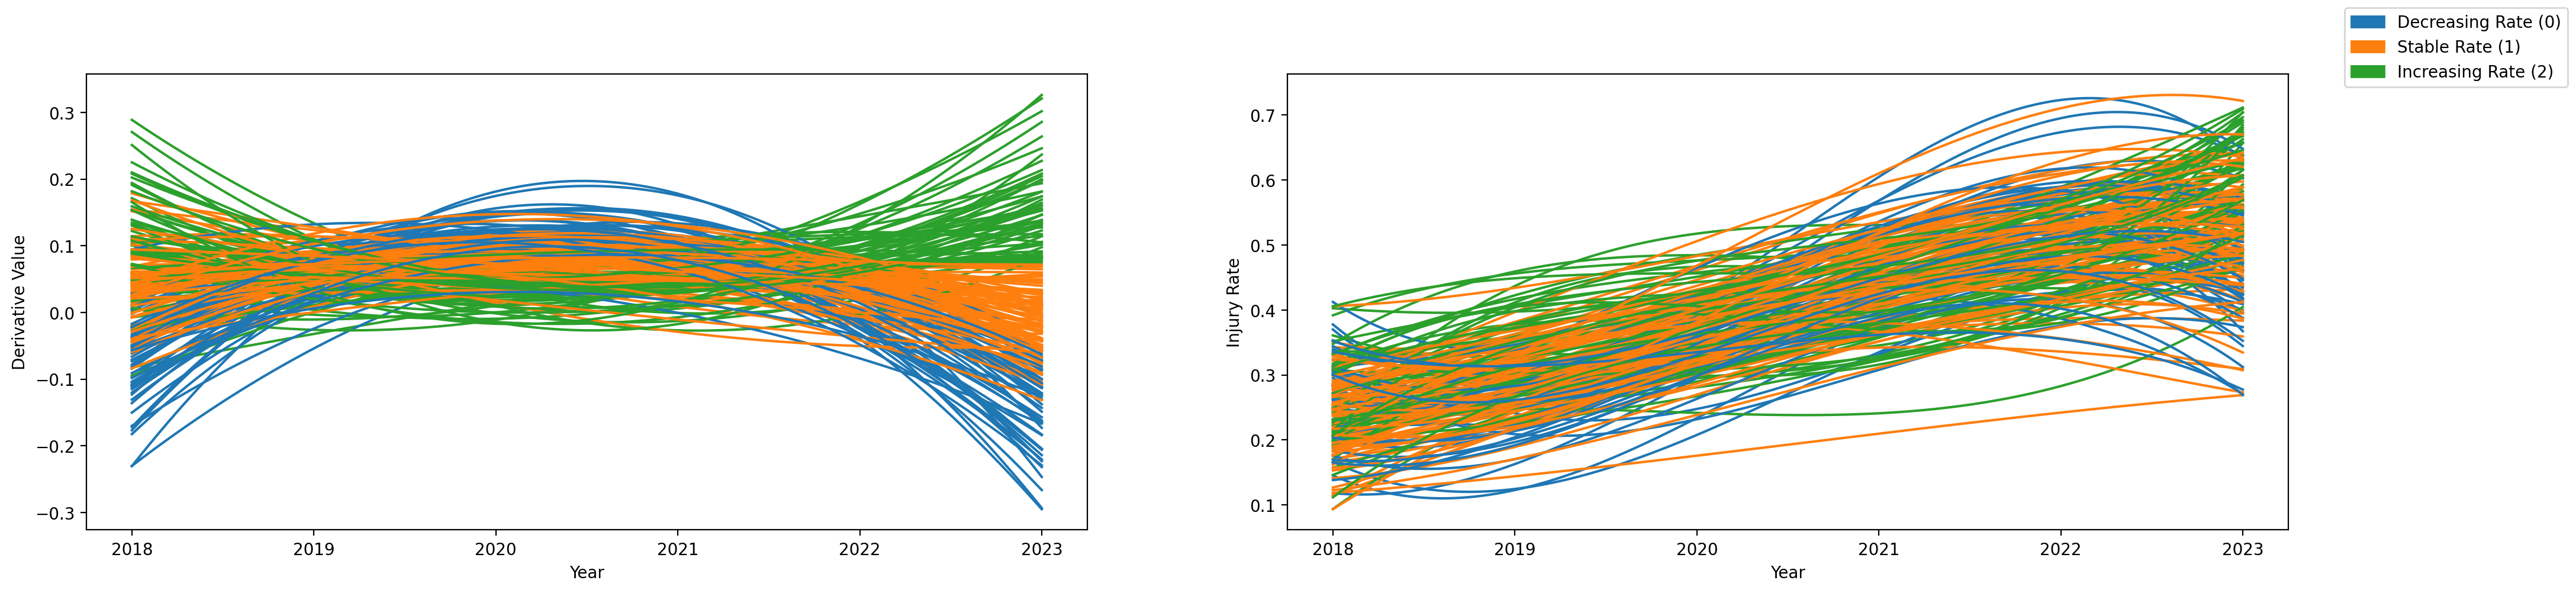

In [20]:
fda_data = streets.merge(temp, on = ['ON STREET NAME'], how = 'inner').pivot(values = 'INJURY_RATE', index = ['ON STREET NAME'], columns=['YEAR']).fillna(0.0)

fd = skfda.FDataGrid(
    data_matrix=fda_data,
    grid_points=[2018,2019,2020,2021,2022,2023])

basis = skfda.representation.basis.BSplineBasis(domain_range=(2018,2023), n_basis=4, order=4)
fd_t = fd.to_basis(basis)

fdd = fd_t.derivative()
clusterer = skfda.ml.clustering.KMeans(n_clusters=3)
fdd_y_pred = clusterer.fit_predict(fdd.to_grid())

# Set Figure properties
fig, axes = plt.subplots(ncols = 2, nrows = 1)

fdd.plot(group=fdd_y_pred, legend = True, group_names = ['Decreasing Rate (0)', 'Stable Rate (1)', 'Increasing Rate (2)'], axes = axes[0])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Derivative Value')

fd_t.plot(group=fdd_y_pred, axes = axes[1])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Injury Rate')

plt.show()

## Clustering Sneak Peek

The tables below unveil the clustering results. Cluster 0 exhibits peaks in 2021 and 2022, followed by subsequent dips — an evident sign of slowing down or reduction. Cluster 1 demonstrates stable rates or slow increases over the years, while Cluster 3 illustrates stable increases that seem to be accelerating, exemplified by streets like "111 Avenue."

In [21]:
# Add labels to the data
fda_data['Cluster'] = fdd_y_pred
fda_data[fda_data['Cluster'] == 0].head(1)

YEAR,2018,2019,2020,2021,2022,2023,Cluster
ON STREET NAME,,,,,,,
10 AVENUE,0.15,0.11,0.24,0.39,0.43,0.35,0


In [22]:
fda_data[fda_data['Cluster'] == 1].head(1)

YEAR,2018,2019,2020,2021,2022,2023,Cluster
ON STREET NAME,,,,,,,
1 AVENUE,0.23,0.26,0.32,0.46,0.45,0.46,1


In [23]:
fda_data[fda_data['Cluster'] == 2].head(1)

YEAR,2018,2019,2020,2021,2022,2023,Cluster
ON STREET NAME,,,,,,,
111 AVENUE,0.31,0.38,0.28,0.35,0.44,0.58,2


## Hotspot Results

In the final tables below presenting streets associated with each borough for Group 0, Group 1, and Group 2, Brooklyn, Queens, and Manhattan emerge as the top three boroughs with the most streets linked to substantial increases in injury rates (Group 2). Furthermore, Brooklyn and Queens are at the top of Group 1 as well, indicating stable but slower increases through the years. This consistent pattern across both clustering groups provides a clear directive for the police force to prioritize these areas, focusing particularly on Brooklyn and Queens.

Additionally, while I recommend concentrating efforts on Brooklyn and Queens, it is crucial to understand the factors contributing to the substantial increase in injury rates in Manhattan, which initially had the lowest rates.

Moreover, there is some overlap in the data, with streets like "Third Avenue" and "Fulton Street" appearing in more than one borough. Despite this, the provided list of streets should aid police forces in narrowing down their focus and investigating the factors contributing to the significant increase in injury rates on these specific streets.

Furthermore, these results validate our earlier models that hinted at an increase in injury rates in Manhattan, as it prominently features in our Top 3 boroughs with streets becoming injury hotspots.

In [24]:
# Split data into groups
group_0 = fda_data[fda_data['Cluster'] == 0]
group_1 = fda_data[fda_data['Cluster'] == 1]
group_2 = fda_data[fda_data['Cluster'] == 2]

# Obtain Group Information
group_0_streets = filtered_df[filtered_df['ON STREET NAME'] != 'NAN'].merge(pd.DataFrame.from_dict({'ON STREET NAME' : group_0.index.to_list()}), on = ['ON STREET NAME'], how = 'inner')
group_1_streets = filtered_df[filtered_df['ON STREET NAME'] != 'NAN'].merge(pd.DataFrame.from_dict({'ON STREET NAME' : group_1.index.to_list()}), on = ['ON STREET NAME'], how = 'inner')
group_2_streets = filtered_df[filtered_df['ON STREET NAME'] != 'NAN'].merge(pd.DataFrame.from_dict({'ON STREET NAME' : group_2.index.to_list()}), on = ['ON STREET NAME'], how = 'inner')

# Group 0 Information
group_0_info = group_0_streets.groupby('BOROUGH').agg(STREETS = ('ON STREET NAME', 'unique'))
group_0_info['STREET COUNT'] = group_0_info['STREETS'].apply(len)
group_0_info = group_0_info.sort_values('STREET COUNT', ascending = False)

# Group 1 Information
group_1_info = group_1_streets.groupby('BOROUGH').agg(STREETS = ('ON STREET NAME', 'unique'))
group_1_info['STREET COUNT'] = group_1_info['STREETS'].apply(len)
group_1_info = group_1_info.sort_values('STREET COUNT', ascending = False)

# Group 2 Information
group_2_info = group_2_streets.groupby('BOROUGH').agg(STREETS = ('ON STREET NAME', 'unique'))
group_2_info['STREET COUNT'] = group_2_info['STREETS'].apply(len)
group_2_info = group_2_info.sort_values('STREET COUNT', ascending = False)

In [25]:
group_0_info

,STREETS,STREET COUNT
BOROUGH,,
BROOKLYN,"[3 AVENUE, GRAND STREET, 12 AVENUE, FLUSHING A...",36
QUEENS,"[3 AVENUE, 12 AVENUE, FLUSHING AVENUE, 65 STRE...",27
MANHATTAN,"[3 AVENUE, GRAND STREET, 12 AVENUE, 65 STREET,...",18
BRONX,"[3 AVENUE, EAST 167 STREET, WEST STREET, WASHI...",9
STATEN ISLAND,"[CENTRAL AVENUE, WEST STREET, RALPH AVENUE, HO...",7


In [26]:
group_1_info

,STREETS,STREET COUNT
BOROUGH,,
BROOKLYN,"[FULTON STREET, AVENUE J, UTICA AVENUE, JAMAIC...",54
QUEENS,"[SPRINGFIELD BOULEVARD, JAMAICA AVENUE, QUEENS...",33
STATEN ISLAND,"[VICTORY BOULEVARD, FULTON STREET, ATLANTIC AV...",21
BRONX,"[WHITE PLAINS ROAD, WEST FORDHAM ROAD, EAST FO...",19
MANHATTAN,"[FULTON STREET, 1 AVENUE, MANHATTAN AVENUE, AV...",18


In [27]:
group_2_info

,STREETS,STREET COUNT
BOROUGH,,
BROOKLYN,"[21 STREET, SAINT NICHOLAS AVENUE, GRAND AVENU...",33
QUEENS,"[NORTH CONDUIT AVENUE, 21 STREET, SAINT NICHOL...",31
MANHATTAN,"[21 STREET, SAINT NICHOLAS AVENUE, 5 AVENUE, W...",14
BRONX,"[GRAND AVENUE, GRAND CONCOURSE, 5 AVENUE, FORE...",12
STATEN ISLAND,"[GRAND AVENUE, MARCY AVENUE, BEDFORD AVENUE, F...",9


# Conclusion

In conclusion, this analysis of motor vehicle collisions in New York City has revealed a substantial increase in injury rates since 2019, with a pronounced surge observed from 2020 onwards. Our models successfully explained temporal and borough-wise variations in injury rates, emphasizing the importance of focusing on injuries over deaths due to their growing and higher occurrence.

Utilizing Functional Data analysis and clustering, we identify specific streets experiencing significant increases in injury rates. Brooklyn, Queens, and Manhattan emerge as hotspots, with Brooklyn and Queens showing both substantial and slower increases. This information provides a clear directive for law enforcement to prioritize monitoring and control measures in these areas.

Identified streets, such as "21 Street" and "Saint Nicholas Avenue", offer valuable insights as focal points for police investigations, aiding in understanding and addressing factors contributing to the significant increase in injury rates.

In essence, our findings offer actionable intelligence for law enforcement to address rising injury rates, prioritize efforts in specific boroughs and streets, and ultimately enhance public safety in New York City.